# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=20db123b646f91521f657026815a74635fe1f94860064a81c0a02e4bc7ffda5d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=479656be470b3c64dec9b0d62f608e796428664d484ae1dcc64082be09e43857
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

sigmoid = nn.Sigmoid()
if torch.cuda.is_available():
    sigmoid = sigmoid.cuda()

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        out = self.outc(x)
        if not self.training:
            out = sigmoid(out)
            out = torch.where(out>0.5,torch.ones_like(out),torch.zeros_like(out))
        return out

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        img_paths = list(Path(img_dir).glob("*"))
        mask_paths = list(Path(mask_dir).glob("*"))
        self.images = []
        self.masks = []
        for img_idx in range(len(img_paths)):
            img_path = img_paths[img_idx]
            img = self.load_image(img_path)
            num_channels = len(img.getbands())
            if num_channels != 3:
                continue
            
            mask_path = mask_paths[img_idx]
            mask = self.load_image(mask_path)
            self.images.append(img)
            self.masks.append(mask)
            
        # 设置 transforms
        self.transform = v2.Compose([     v2.Resize(size), 
                                             v2.RandomHorizontalFlip(),  # 随机水平翻转
                                             v2.RandomVerticalFlip(),    # 随机垂直旋转
                                             v2.RandomRotation(10) ,     # 随机旋转 （-10,10）度
                                             v2.ToImageTensor(), v2.ConvertImageDtype()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    def load_image(self, path) -> Image.Image:
        "Opens an image via a path and returns it."
        return Image.open(path).copy()
    
    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.images[index]
        mask_img = self.masks[index]
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        mask_img = self.transform(mask_img)
        
        mask_img = torch.where(mask_img>0.5,torch.ones_like(mask_img),torch.zeros_like(mask_img))
        return orig_img, mask_img


# 加载数据集

In [6]:
batch_size=8

dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=batch_size,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 572, train_size: 457, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
showing image of 75: 


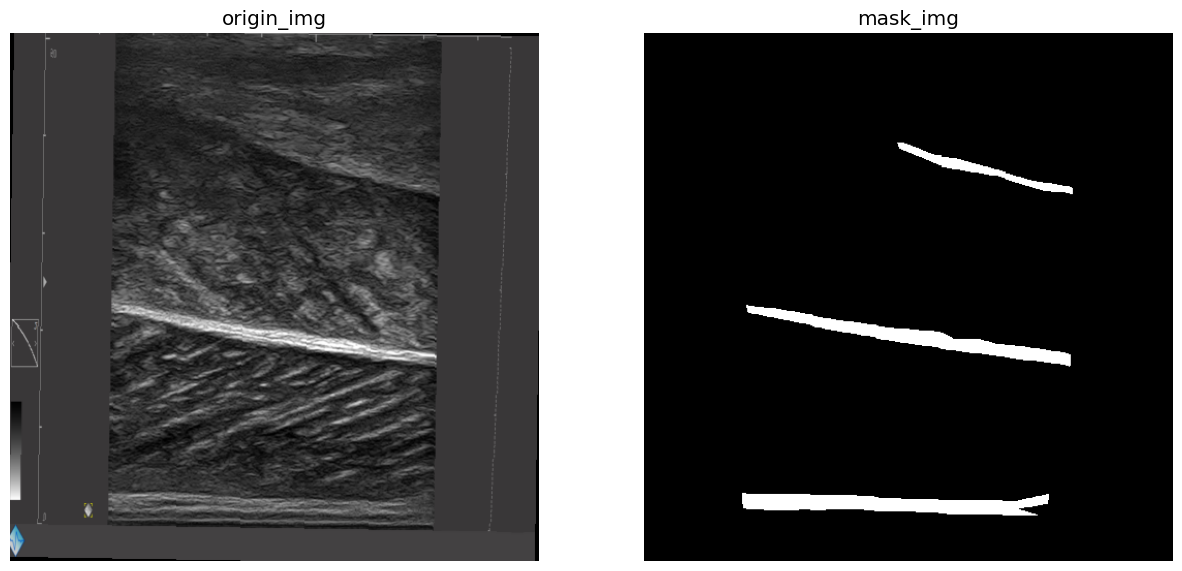

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]

print(orig_img.size())
print(mask_img.size())


print("showing image of {}: ".format(idx))

orig_img = orig_img.cpu().numpy().transpose(1, 2, 0)
mask_img = mask_img.cpu().numpy().transpose(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.grid(False)
ax1.axis('off')
ax1.set_title("origin_img")

ax2.imshow(mask_img, cmap="gray")
ax2.grid(False)
ax2.axis('off')
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login


# (Initialize logging)
experiment = wandb.init(project='U-Net', resume='allow', anonymous='must', notes='水平和垂直翻转，旋转(-10,10)度')
experiment.config.update(
    dict(epochs=200, batch_size=batch_size, amp=True)
)

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240131_031016-y62nlsuh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cerulean-microwave-94
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/U-Net
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/U-Net/runs/y62nlsuh


In [10]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    if torch.cuda.is_available():
        criterion = criterion.cuda()
        dice_loss = dice_loss.cuda()
        
    
    print("Validation round")
    # iterate over the validation set
#     with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
        images, mask_trues = batch

         # move images and labels to correct device and type
        images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        mask_trues = mask_trues.to(device=device, dtype=torch.float32)

        # predict the mask
        mask_preds = net(images)
        dice_score += criterion(mask_preds, mask_trues.float())
        dice_score += dice_loss(mask_preds, mask_trues)
            
        tp, fp, fn, tn = smp.metrics.get_stats(mask_preds, mask_trues.long(), mode='binary', threshold=0.5)
        iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    
    try:
        histograms = {}
        for tag, value in net.named_parameters():
            tag = tag.replace('/', '.')
            if not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

        experiment.log({
            'validation Dice Loss': dice_loss,
            'validation IoU Score': iou_score,
            'images': wandb.Image(images[0].cpu()),
            'masks': {
                'true': wandb.Image(mask_trues[0].float().cpu()),
                'pred': wandb.Image(mask_preds[0].float().cpu()),
            },
            **histograms
        })
    except Exception as e:
        print(e)
#         pass
    
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 200,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 6,
          amp: bool = False,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice scor
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()

    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (2 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device, batch_size=batch_size)

    

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

Epoch 1/200:  49%|████▉     | 224/457 [00:35<00:32,  7.10img/s, loss (batch)=1.44]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.42batch/s]


Validation dice loss: 1.6521762609481812, IoU Score 0.18666903674602509


Epoch 1/200:  98%|█████████▊| 448/457 [01:21<00:01,  6.80img/s, loss (batch)=1.34]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6502749919891357, IoU Score 0.2650718688964844


Epoch 2/200:  46%|████▌     | 208/457 [00:30<00:37,  6.72img/s, loss (batch)=1.32]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6463350057601929, IoU Score 0.26790472865104675


Epoch 2/200:  95%|█████████▍| 432/457 [01:18<00:03,  6.60img/s, loss (batch)=1.25]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6157506704330444, IoU Score 0.40165984630584717


Epoch 3/200:  42%|████▏     | 192/457 [00:29<00:40,  6.54img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.607998013496399, IoU Score 0.46748799085617065


Epoch 3/200:  91%|█████████ | 416/457 [01:17<00:06,  6.47img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6123703718185425, IoU Score 0.4298844039440155


Epoch 4/200:  39%|███▊      | 176/457 [00:27<00:43,  6.42img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6097066402435303, IoU Score 0.4550803303718567


Epoch 4/200:  88%|████████▊ | 400/457 [01:16<00:08,  6.36img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6075094938278198, IoU Score 0.4803800880908966


Epoch 5/200:  35%|███▌      | 160/457 [00:25<00:47,  6.31img/s, loss (batch)=1.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6054697036743164, IoU Score 0.5018941760063171


Epoch 5/200:  84%|████████▍ | 384/457 [01:14<00:11,  6.35img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6073951721191406, IoU Score 0.48193928599357605


Epoch 6/200:  32%|███▏      | 144/457 [00:22<00:49,  6.36img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6039830446243286, IoU Score 0.5201141238212585


Epoch 6/200:  81%|████████  | 368/457 [01:11<00:13,  6.41img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.60329008102417, IoU Score 0.5271177291870117


Epoch 7/200:  28%|██▊       | 128/457 [00:20<00:51,  6.34img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.604743242263794, IoU Score 0.5148613452911377


Epoch 7/200:  77%|███████▋  | 352/457 [01:09<00:16,  6.39img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6028084754943848, IoU Score 0.5363520383834839


Epoch 8/200:  25%|██▍       | 112/457 [00:17<00:55,  6.27img/s, loss (batch)=1.09] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6030131578445435, IoU Score 0.5316677689552307


Epoch 8/200:  74%|███████▎  | 336/457 [01:06<00:18,  6.42img/s, loss (batch)=0.978]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6037768125534058, IoU Score 0.5238125324249268


Epoch 9/200:  21%|██        | 96/457 [00:14<00:56,  6.44img/s, loss (batch)=0.973]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.6020718812942505, IoU Score 0.5466704368591309


Epoch 9/200:  70%|███████   | 320/457 [01:03<00:21,  6.43img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.6012334823608398, IoU Score 0.5598592758178711


Epoch 10/200:  18%|█▊        | 80/457 [00:12<00:58,  6.46img/s, loss (batch)=0.938]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6008938550949097, IoU Score 0.5646070837974548


Epoch 10/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.41img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.600579023361206, IoU Score 0.5728939771652222


Epoch 11/200:  14%|█▍        | 64/457 [00:10<01:01,  6.38img/s, loss (batch)=0.994]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6036227941513062, IoU Score 0.5313025116920471


Epoch 11/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.45img/s, loss (batch)=0.921]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6016606092453003, IoU Score 0.5590630173683167


Epoch 12/200:  11%|█         | 48/457 [00:07<01:03,  6.44img/s, loss (batch)=0.917]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6012388467788696, IoU Score 0.5655579566955566


Epoch 12/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.47img/s, loss (batch)=0.985]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6004700660705566, IoU Score 0.5783827900886536


Epoch 13/200:   7%|▋         | 32/457 [00:05<01:06,  6.41img/s, loss (batch)=0.976]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.6025323867797852, IoU Score 0.5445713996887207


Epoch 13/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.34img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6021538972854614, IoU Score 0.5468677282333374


Epoch 14/200:   4%|▎         | 16/457 [00:02<01:09,  6.36img/s, loss (batch)=0.969]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.6012659072875977, IoU Score 0.5595947504043579


Epoch 14/200:  53%|█████▎    | 240/457 [00:51<00:33,  6.44img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6007722616195679, IoU Score 0.5669494867324829


Epoch 14/200: 100%|██████████| 457/457 [01:38<00:00,  6.12img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.6011147499084473, IoU Score 0.5658524036407471


Epoch 15/200:  49%|████▉     | 224/457 [00:34<00:36,  6.43img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.6015146970748901, IoU Score 0.5611060261726379


Epoch 15/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.42img/s, loss (batch)=0.98] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.601033329963684, IoU Score 0.5660847425460815


Epoch 16/200:  46%|████▌     | 208/457 [00:31<00:38,  6.44img/s, loss (batch)=0.944]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.6016324758529663, IoU Score 0.559097170829773


Epoch 16/200:  95%|█████████▍| 432/457 [01:19<00:03,  6.46img/s, loss (batch)=0.946]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.600266933441162, IoU Score 0.5792665481567383


Epoch 17/200:  42%|████▏     | 192/457 [00:29<00:41,  6.39img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.600506067276001, IoU Score 0.5750656723976135


Epoch 17/200:  91%|█████████ | 416/457 [01:17<00:06,  6.46img/s, loss (batch)=0.858]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6014500856399536, IoU Score 0.5638132095336914


Epoch 18/200:  39%|███▊      | 176/457 [00:27<00:43,  6.44img/s, loss (batch)=0.954]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.6012933254241943, IoU Score 0.5624709725379944


Epoch 18/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.45img/s, loss (batch)=0.899]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.601765751838684, IoU Score 0.5573212504386902


Epoch 19/200:  35%|███▌      | 160/457 [00:24<00:46,  6.41img/s, loss (batch)=0.884]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6024518013000488, IoU Score 0.5459141731262207


Epoch 19/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.41img/s, loss (batch)=0.916]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.602358102798462, IoU Score 0.5511563420295715


Epoch 20/200:  32%|███▏      | 144/457 [00:22<00:48,  6.40img/s, loss (batch)=0.883]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.6003445386886597, IoU Score 0.5765171051025391


Epoch 20/200:  81%|████████  | 368/457 [01:10<00:13,  6.43img/s, loss (batch)=0.835]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5998529195785522, IoU Score 0.5834679007530212


Epoch 21/200:  28%|██▊       | 128/457 [00:19<00:51,  6.41img/s, loss (batch)=0.94] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.6002018451690674, IoU Score 0.5824622511863708


Epoch 21/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.48img/s, loss (batch)=0.859]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.60080087184906, IoU Score 0.5712071657180786


Epoch 22/200:  25%|██▍       | 112/457 [00:17<00:54,  6.38img/s, loss (batch)=0.893]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.6004034280776978, IoU Score 0.5807601809501648


Epoch 22/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.47img/s, loss (batch)=0.897]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.600754737854004, IoU Score 0.5768190026283264


Epoch 23/200:  21%|██        | 96/457 [00:14<00:56,  6.42img/s, loss (batch)=0.826]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6021292209625244, IoU Score 0.5524306297302246


Epoch 23/200:  70%|███████   | 320/457 [01:03<00:21,  6.45img/s, loss (batch)=0.852]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.600014090538025, IoU Score 0.591504693031311


Epoch 24/200:  18%|█▊        | 80/457 [00:12<00:58,  6.42img/s, loss (batch)=0.898]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5993846654891968, IoU Score 0.5925924181938171


Epoch 24/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.49img/s, loss (batch)=0.805]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5994645357131958, IoU Score 0.5907047390937805


Epoch 25/200:  14%|█▍        | 64/457 [00:09<01:01,  6.43img/s, loss (batch)=0.847]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.6008707284927368, IoU Score 0.577883243560791


Epoch 25/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.42img/s, loss (batch)=0.886]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.600469946861267, IoU Score 0.5826878547668457


Epoch 26/200:  11%|█         | 48/457 [00:07<01:03,  6.44img/s, loss (batch)=0.823]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.6004668474197388, IoU Score 0.5818454623222351


Epoch 26/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.53img/s, loss (batch)=0.741]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.600231409072876, IoU Score 0.5845174789428711


Epoch 27/200:   7%|▋         | 32/457 [00:05<01:06,  6.38img/s, loss (batch)=0.781]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.6008415222167969, IoU Score 0.5793768763542175


Epoch 27/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.46img/s, loss (batch)=0.767]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6006731986999512, IoU Score 0.5730700492858887


Epoch 28/200:   4%|▎         | 16/457 [00:02<01:08,  6.43img/s, loss (batch)=0.934]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5993010997772217, IoU Score 0.5989851355552673


Epoch 28/200:  53%|█████▎    | 240/457 [00:51<00:33,  6.41img/s, loss (batch)=0.828]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5993974208831787, IoU Score 0.6026128530502319


Epoch 28/200: 100%|██████████| 457/457 [01:38<00:00,  6.18img/s, loss (batch)=0.788]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.599260687828064, IoU Score 0.6013202667236328


Epoch 29/200:  49%|████▉     | 224/457 [00:34<00:36,  6.45img/s, loss (batch)=0.768]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5995969772338867, IoU Score 0.5997810363769531


Epoch 29/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.41img/s, loss (batch)=0.815]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5994887351989746, IoU Score 0.5990098118782043


Epoch 30/200:  46%|████▌     | 208/457 [00:31<00:38,  6.45img/s, loss (batch)=0.775]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.599457025527954, IoU Score 0.5937920808792114


Epoch 30/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.44img/s, loss (batch)=0.779]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5997017621994019, IoU Score 0.5917789340019226


Epoch 31/200:  42%|████▏     | 192/457 [00:29<00:41,  6.37img/s, loss (batch)=0.882]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5989367961883545, IoU Score 0.6027795672416687


Epoch 31/200:  91%|█████████ | 416/457 [01:17<00:06,  6.41img/s, loss (batch)=0.783]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5998338460922241, IoU Score 0.5868619680404663


Epoch 32/200:  39%|███▊      | 176/457 [00:27<00:43,  6.44img/s, loss (batch)=0.733]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5999476909637451, IoU Score 0.5931115746498108


Epoch 32/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.51img/s, loss (batch)=0.732]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5999032258987427, IoU Score 0.5905665755271912


Epoch 33/200:  35%|███▌      | 160/457 [00:24<00:45,  6.46img/s, loss (batch)=0.734]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5997012853622437, IoU Score 0.5905799269676208


Epoch 33/200:  84%|████████▍ | 384/457 [01:12<00:11,  6.40img/s, loss (batch)=0.765]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.599216103553772, IoU Score 0.6024477481842041


Epoch 34/200:  32%|███▏      | 144/457 [00:22<00:48,  6.40img/s, loss (batch)=0.732]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.21batch/s]


Validation dice loss: 1.600398302078247, IoU Score 0.583487331867218


Epoch 34/200:  81%|████████  | 368/457 [01:10<00:13,  6.45img/s, loss (batch)=0.684]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5991201400756836, IoU Score 0.6062229871749878


Epoch 35/200:  28%|██▊       | 128/457 [00:19<00:51,  6.43img/s, loss (batch)=0.774]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.23batch/s]


Validation dice loss: 1.5985586643218994, IoU Score 0.6045850515365601


Epoch 35/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.43img/s, loss (batch)=0.778]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5996512174606323, IoU Score 0.5882145762443542


Epoch 36/200:  25%|██▍       | 112/457 [00:17<00:53,  6.45img/s, loss (batch)=0.718]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5991487503051758, IoU Score 0.6050366759300232


Epoch 36/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.49img/s, loss (batch)=0.69] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5996679067611694, IoU Score 0.5975891351699829


Epoch 37/200:  21%|██        | 96/457 [00:14<00:56,  6.44img/s, loss (batch)=0.7]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5990948677062988, IoU Score 0.6034471988677979


Epoch 37/200:  70%|███████   | 320/457 [01:03<00:21,  6.45img/s, loss (batch)=0.731]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5994155406951904, IoU Score 0.6067907214164734


Epoch 38/200:  18%|█▊        | 80/457 [00:12<00:58,  6.44img/s, loss (batch)=0.762]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5982917547225952, IoU Score 0.618096649646759


Epoch 38/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.47img/s, loss (batch)=0.773]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.59866201877594, IoU Score 0.6165487766265869


Epoch 39/200:  14%|█▍        | 64/457 [00:09<01:01,  6.44img/s, loss (batch)=0.703]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5998361110687256, IoU Score 0.5942127704620361


Epoch 39/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.37img/s, loss (batch)=0.67]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5982733964920044, IoU Score 0.6205916404724121


Epoch 40/200:  11%|█         | 48/457 [00:07<01:03,  6.49img/s, loss (batch)=0.651]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5991601943969727, IoU Score 0.6030671000480652


Epoch 40/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.39img/s, loss (batch)=0.696]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5989428758621216, IoU Score 0.6076557040214539


Epoch 41/200:   7%|▋         | 32/457 [00:04<01:06,  6.44img/s, loss (batch)=0.704]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5980558395385742, IoU Score 0.6227285861968994


Epoch 41/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.36img/s, loss (batch)=0.71] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.21batch/s]


Validation dice loss: 1.5984399318695068, IoU Score 0.6204431653022766


Epoch 42/200:   4%|▎         | 16/457 [00:02<01:08,  6.42img/s, loss (batch)=0.675]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.599183201789856, IoU Score 0.6053503751754761


Epoch 42/200:  53%|█████▎    | 240/457 [00:50<00:33,  6.49img/s, loss (batch)=0.701]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5981876850128174, IoU Score 0.6192773580551147


Epoch 42/200: 100%|██████████| 457/457 [01:37<00:00,  6.11img/s, loss (batch)=0.8]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5983822345733643, IoU Score 0.6147651672363281


Epoch 43/200:  49%|████▉     | 224/457 [00:34<00:36,  6.43img/s, loss (batch)=0.667]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.21batch/s]


Validation dice loss: 1.5986484289169312, IoU Score 0.616340160369873


Epoch 43/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.44img/s, loss (batch)=0.676]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5989667177200317, IoU Score 0.6114121079444885


Epoch 44/200:  46%|████▌     | 208/457 [00:31<00:38,  6.48img/s, loss (batch)=0.653]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5980867147445679, IoU Score 0.6241187453269958


Epoch 44/200:  95%|█████████▍| 432/457 [01:19<00:03,  6.46img/s, loss (batch)=0.766]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5982860326766968, IoU Score 0.6202268600463867


Epoch 45/200:  42%|████▏     | 192/457 [00:29<00:41,  6.45img/s, loss (batch)=0.678]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.598427653312683, IoU Score 0.6220055222511292


Epoch 45/200:  91%|█████████ | 416/457 [01:17<00:06,  6.44img/s, loss (batch)=0.671]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5987883806228638, IoU Score 0.6093581318855286


Epoch 46/200:  39%|███▊      | 176/457 [00:27<00:43,  6.45img/s, loss (batch)=0.587]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.20batch/s]


Validation dice loss: 1.5983117818832397, IoU Score 0.6219721436500549


Epoch 46/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.44img/s, loss (batch)=0.718]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.20batch/s]


Validation dice loss: 1.5983929634094238, IoU Score 0.6266671419143677


Epoch 47/200:  35%|███▌      | 160/457 [00:24<00:46,  6.46img/s, loss (batch)=0.607]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5989346504211426, IoU Score 0.6086998581886292


Epoch 47/200:  84%|████████▍ | 384/457 [01:12<00:11,  6.44img/s, loss (batch)=0.664]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.20batch/s]


Validation dice loss: 1.599135160446167, IoU Score 0.6073505282402039


Epoch 48/200:  32%|███▏      | 144/457 [00:22<00:48,  6.41img/s, loss (batch)=0.755]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5974888801574707, IoU Score 0.6387632489204407


Epoch 48/200:  81%|████████  | 368/457 [01:10<00:13,  6.50img/s, loss (batch)=0.684]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5972003936767578, IoU Score 0.6409034132957458


Epoch 49/200:  28%|██▊       | 128/457 [00:19<00:50,  6.47img/s, loss (batch)=0.635]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5982675552368164, IoU Score 0.614639401435852


Epoch 49/200:  77%|███████▋  | 352/457 [01:07<00:16,  6.48img/s, loss (batch)=0.632]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5976855754852295, IoU Score 0.6267123222351074


Epoch 50/200:  25%|██▍       | 112/457 [00:17<00:53,  6.44img/s, loss (batch)=0.731]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5973162651062012, IoU Score 0.6388001441955566


Epoch 50/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.48img/s, loss (batch)=0.542]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5979173183441162, IoU Score 0.6329548954963684


Epoch 51/200:  21%|██        | 96/457 [00:14<00:56,  6.43img/s, loss (batch)=0.543]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5979748964309692, IoU Score 0.6299392580986023


Epoch 51/200:  70%|███████   | 320/457 [01:03<00:21,  6.41img/s, loss (batch)=0.639]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.59775972366333, IoU Score 0.6305239200592041


Epoch 52/200:  18%|█▊        | 80/457 [00:12<00:58,  6.40img/s, loss (batch)=0.615]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5980935096740723, IoU Score 0.6288891434669495


Epoch 52/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.46img/s, loss (batch)=0.607]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5973998308181763, IoU Score 0.6409662365913391


Epoch 53/200:  14%|█▍        | 64/457 [00:09<01:00,  6.50img/s, loss (batch)=0.647]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5976728200912476, IoU Score 0.6360272765159607


Epoch 53/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.48img/s, loss (batch)=0.605]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5976873636245728, IoU Score 0.6345967650413513


Epoch 54/200:  11%|█         | 48/457 [00:07<01:03,  6.42img/s, loss (batch)=0.571]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5975639820098877, IoU Score 0.6455184817314148


Epoch 54/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.51img/s, loss (batch)=0.588]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.21batch/s]


Validation dice loss: 1.5979948043823242, IoU Score 0.6294146180152893


Epoch 55/200:   7%|▋         | 32/457 [00:04<01:05,  6.47img/s, loss (batch)=0.559]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5972288846969604, IoU Score 0.6403688788414001


Epoch 55/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.45img/s, loss (batch)=0.53] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5972068309783936, IoU Score 0.6418545246124268


Epoch 56/200:   4%|▎         | 16/457 [00:02<01:07,  6.56img/s, loss (batch)=0.536]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.598059058189392, IoU Score 0.626538872718811


Epoch 56/200:  53%|█████▎    | 240/457 [00:50<00:33,  6.39img/s, loss (batch)=0.622]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5974928140640259, IoU Score 0.6353803277015686


Epoch 56/200: 100%|██████████| 457/457 [01:38<00:00,  6.15img/s, loss (batch)=0.451]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.59726881980896, IoU Score 0.6469062566757202


Epoch 57/200:  49%|████▉     | 224/457 [00:34<00:36,  6.47img/s, loss (batch)=0.543]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5974392890930176, IoU Score 0.6458526849746704


Epoch 57/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.42img/s, loss (batch)=0.557]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5977483987808228, IoU Score 0.6370909214019775


Epoch 58/200:  46%|████▌     | 208/457 [00:31<00:38,  6.48img/s, loss (batch)=0.562]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5978442430496216, IoU Score 0.6384257674217224


Epoch 58/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.46img/s, loss (batch)=0.504]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5968470573425293, IoU Score 0.6525026559829712


Epoch 59/200:  42%|████▏     | 192/457 [00:29<00:41,  6.42img/s, loss (batch)=0.59] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5971688032150269, IoU Score 0.6478984355926514


Epoch 59/200:  91%|█████████ | 416/457 [01:17<00:06,  6.40img/s, loss (batch)=0.606]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.597243309020996, IoU Score 0.6470752954483032


Epoch 60/200:  39%|███▊      | 176/457 [00:27<00:44,  6.35img/s, loss (batch)=0.553]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5972157716751099, IoU Score 0.6449869275093079


Epoch 60/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.49img/s, loss (batch)=0.51]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5978176593780518, IoU Score 0.6320617198944092


Epoch 61/200:  35%|███▌      | 160/457 [00:24<00:46,  6.43img/s, loss (batch)=0.566]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.596896767616272, IoU Score 0.6447438597679138


Epoch 61/200:  84%|████████▍ | 384/457 [01:12<00:11,  6.50img/s, loss (batch)=0.49] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5969454050064087, IoU Score 0.6445262432098389


Epoch 62/200:  32%|███▏      | 144/457 [00:22<00:48,  6.46img/s, loss (batch)=0.594]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5978394746780396, IoU Score 0.6405467987060547


Epoch 62/200:  81%|████████  | 368/457 [01:10<00:13,  6.49img/s, loss (batch)=0.565]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5969725847244263, IoU Score 0.6535983681678772


Epoch 63/200:  28%|██▊       | 128/457 [00:19<00:51,  6.45img/s, loss (batch)=0.521]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5967477560043335, IoU Score 0.6473444700241089


Epoch 63/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.45img/s, loss (batch)=0.545]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5972155332565308, IoU Score 0.6462827920913696


Epoch 64/200:  25%|██▍       | 112/457 [00:17<00:53,  6.47img/s, loss (batch)=0.506]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.597055196762085, IoU Score 0.6468346118927002


Epoch 64/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.42img/s, loss (batch)=0.548]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.597047209739685, IoU Score 0.6452706456184387


Epoch 65/200:  21%|██        | 96/457 [00:14<00:55,  6.48img/s, loss (batch)=0.578]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5978847742080688, IoU Score 0.6426124572753906


Epoch 65/200:  70%|███████   | 320/457 [01:03<00:21,  6.46img/s, loss (batch)=0.592]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.20batch/s]


Validation dice loss: 1.597309947013855, IoU Score 0.6458736062049866


Epoch 66/200:  18%|█▊        | 80/457 [00:12<00:58,  6.47img/s, loss (batch)=0.471]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5978128910064697, IoU Score 0.6420226693153381


Epoch 66/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.42img/s, loss (batch)=0.491]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5966836214065552, IoU Score 0.6609333753585815


Epoch 67/200:  14%|█▍        | 64/457 [00:09<01:00,  6.47img/s, loss (batch)=0.47] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5969815254211426, IoU Score 0.6485169529914856


Epoch 67/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.40img/s, loss (batch)=0.508]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.596860647201538, IoU Score 0.6527806520462036


Epoch 68/200:  11%|█         | 48/457 [00:07<01:03,  6.40img/s, loss (batch)=0.561]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5973999500274658, IoU Score 0.6433244943618774


Epoch 68/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.46img/s, loss (batch)=0.425]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5963436365127563, IoU Score 0.6575098037719727


Epoch 69/200:   7%|▋         | 32/457 [00:04<01:05,  6.48img/s, loss (batch)=0.554]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5963374376296997, IoU Score 0.6629601120948792


Epoch 69/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.45img/s, loss (batch)=0.485]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5967820882797241, IoU Score 0.653984546661377


Epoch 70/200:   4%|▎         | 16/457 [00:02<01:08,  6.45img/s, loss (batch)=0.517]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.59689199924469, IoU Score 0.6527576446533203


Epoch 70/200:  53%|█████▎    | 240/457 [00:50<00:33,  6.41img/s, loss (batch)=0.543]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.597139596939087, IoU Score 0.6533389091491699


Epoch 70/200: 100%|██████████| 457/457 [01:38<00:00,  6.15img/s, loss (batch)=0.473]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5965739488601685, IoU Score 0.6577907800674438


Epoch 71/200:  49%|████▉     | 224/457 [00:34<00:36,  6.42img/s, loss (batch)=0.514]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5964502096176147, IoU Score 0.6635131239891052


Epoch 71/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.41img/s, loss (batch)=0.464]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5971946716308594, IoU Score 0.6485281586647034


Epoch 72/200:  46%|████▌     | 208/457 [00:31<00:38,  6.45img/s, loss (batch)=0.451]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5964717864990234, IoU Score 0.6613725423812866


Epoch 72/200:  95%|█████████▍| 432/457 [01:19<00:03,  6.47img/s, loss (batch)=0.523]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5968927145004272, IoU Score 0.6547005772590637


Epoch 73/200:  42%|████▏     | 192/457 [00:29<00:41,  6.40img/s, loss (batch)=0.47] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5962287187576294, IoU Score 0.6667027473449707


Epoch 73/200:  91%|█████████ | 416/457 [01:17<00:06,  6.45img/s, loss (batch)=0.538]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5962257385253906, IoU Score 0.6702614426612854


Epoch 74/200:  39%|███▊      | 176/457 [00:27<00:43,  6.41img/s, loss (batch)=0.416]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5961549282073975, IoU Score 0.6657108068466187


Epoch 74/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.44img/s, loss (batch)=0.393]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5969053506851196, IoU Score 0.6602498292922974


Epoch 75/200:  35%|███▌      | 160/457 [00:24<00:46,  6.42img/s, loss (batch)=0.525]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5965805053710938, IoU Score 0.6562048196792603


Epoch 75/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.43img/s, loss (batch)=0.416]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.21batch/s]


Validation dice loss: 1.596467137336731, IoU Score 0.6646246314048767


Epoch 76/200:  32%|███▏      | 144/457 [00:22<00:49,  6.38img/s, loss (batch)=0.412]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5961472988128662, IoU Score 0.6659160852432251


Epoch 76/200:  81%|████████  | 368/457 [01:10<00:13,  6.40img/s, loss (batch)=0.413]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5966682434082031, IoU Score 0.6586278676986694


Epoch 77/200:  28%|██▊       | 128/457 [00:19<00:51,  6.41img/s, loss (batch)=0.476]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5968047380447388, IoU Score 0.6582551002502441


Epoch 77/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.48img/s, loss (batch)=0.41] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5969033241271973, IoU Score 0.6545025110244751


Epoch 78/200:  25%|██▍       | 112/457 [00:17<00:53,  6.42img/s, loss (batch)=0.484]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5963928699493408, IoU Score 0.6626474261283875


Epoch 78/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.46img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5962904691696167, IoU Score 0.6686094403266907


Epoch 79/200:  21%|██        | 96/457 [00:15<00:56,  6.36img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5968151092529297, IoU Score 0.6632100939750671


Epoch 79/200:  70%|███████   | 320/457 [01:03<00:21,  6.49img/s, loss (batch)=0.448]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.595909595489502, IoU Score 0.6683345437049866


Epoch 80/200:  18%|█▊        | 80/457 [00:12<00:59,  6.36img/s, loss (batch)=0.489]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5970481634140015, IoU Score 0.6581146121025085


Epoch 80/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.43img/s, loss (batch)=0.526]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.59584379196167, IoU Score 0.6699146032333374


Epoch 81/200:  14%|█▍        | 64/457 [00:10<01:01,  6.37img/s, loss (batch)=0.349]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5963432788848877, IoU Score 0.6639887094497681


Epoch 81/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.44img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5966575145721436, IoU Score 0.663901150226593


Epoch 82/200:  11%|█         | 48/457 [00:07<01:04,  6.33img/s, loss (batch)=0.472]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5962671041488647, IoU Score 0.6621558666229248


Epoch 82/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.47img/s, loss (batch)=0.383]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5967496633529663, IoU Score 0.6541866064071655


Epoch 83/200:   7%|▋         | 32/457 [00:04<01:06,  6.42img/s, loss (batch)=0.404]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.596144199371338, IoU Score 0.6694516539573669


Epoch 83/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.48img/s, loss (batch)=0.374]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.596829891204834, IoU Score 0.6554705500602722


Epoch 84/200:   4%|▎         | 16/457 [00:02<01:08,  6.48img/s, loss (batch)=0.378]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5962564945220947, IoU Score 0.6601517796516418


Epoch 84/200:  53%|█████▎    | 240/457 [00:50<00:33,  6.45img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5963410139083862, IoU Score 0.6669837236404419


Epoch 84/200: 100%|██████████| 457/457 [01:38<00:00,  6.14img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5958818197250366, IoU Score 0.6739224195480347


Epoch 85/200:  49%|████▉     | 224/457 [00:34<00:36,  6.46img/s, loss (batch)=0.387]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5962045192718506, IoU Score 0.6696181297302246


Epoch 85/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.39img/s, loss (batch)=0.506]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5959519147872925, IoU Score 0.6750049591064453


Epoch 86/200:  46%|████▌     | 208/457 [00:32<00:39,  6.35img/s, loss (batch)=0.398]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5965536832809448, IoU Score 0.6702889800071716


Epoch 86/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.44img/s, loss (batch)=0.371]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.596415400505066, IoU Score 0.6657751798629761


Epoch 87/200:  42%|████▏     | 192/457 [00:29<00:41,  6.46img/s, loss (batch)=0.385]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.596763253211975, IoU Score 0.6522608399391174


Epoch 87/200:  91%|█████████ | 416/457 [01:17<00:06,  6.46img/s, loss (batch)=0.347]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5962095260620117, IoU Score 0.6702963709831238


Epoch 88/200:  39%|███▊      | 176/457 [00:27<00:43,  6.43img/s, loss (batch)=0.366]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5962393283843994, IoU Score 0.6735140681266785


Epoch 88/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.50img/s, loss (batch)=0.43]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.596118450164795, IoU Score 0.6747321486473083


Epoch 89/200:  35%|███▌      | 160/457 [00:24<00:46,  6.43img/s, loss (batch)=0.383]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5965824127197266, IoU Score 0.6595674753189087


Epoch 89/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.44img/s, loss (batch)=0.417]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.596118450164795, IoU Score 0.671877384185791


Epoch 90/200:  32%|███▏      | 144/457 [00:22<00:48,  6.44img/s, loss (batch)=0.464]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5962601900100708, IoU Score 0.670067548751831


Epoch 90/200:  81%|████████  | 368/457 [01:10<00:13,  6.46img/s, loss (batch)=0.357]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5959481000900269, IoU Score 0.6786977052688599


Epoch 91/200:  28%|██▊       | 128/457 [00:19<00:51,  6.43img/s, loss (batch)=0.373]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.596357822418213, IoU Score 0.6690839529037476


Epoch 91/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.44img/s, loss (batch)=0.333]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5964641571044922, IoU Score 0.6713405251502991


Epoch 92/200:  25%|██▍       | 112/457 [00:17<00:53,  6.42img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5956783294677734, IoU Score 0.6810919642448425


Epoch 92/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.40img/s, loss (batch)=0.35] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5958449840545654, IoU Score 0.6784194707870483


Epoch 93/200:  21%|██        | 96/457 [00:14<00:56,  6.42img/s, loss (batch)=0.364]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5968387126922607, IoU Score 0.6666848063468933


Epoch 93/200:  70%|███████   | 320/457 [01:03<00:21,  6.42img/s, loss (batch)=0.375]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5963071584701538, IoU Score 0.6661733388900757


Epoch 94/200:  18%|█▊        | 80/457 [00:12<00:58,  6.41img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5965813398361206, IoU Score 0.6681739091873169


Epoch 94/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.44img/s, loss (batch)=0.332]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5961859226226807, IoU Score 0.6682395339012146


Epoch 95/200:  14%|█▍        | 64/457 [00:10<01:01,  6.37img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5961215496063232, IoU Score 0.6681120991706848


Epoch 95/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.48img/s, loss (batch)=0.485]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5955002307891846, IoU Score 0.676080584526062


Epoch 96/200:  11%|█         | 48/457 [00:07<01:03,  6.45img/s, loss (batch)=0.317]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5961337089538574, IoU Score 0.6764431595802307


Epoch 96/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.44img/s, loss (batch)=0.463]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5959588289260864, IoU Score 0.6753519177436829


Epoch 97/200:   7%|▋         | 32/457 [00:04<01:06,  6.43img/s, loss (batch)=0.321]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5962857007980347, IoU Score 0.6718537211418152


Epoch 97/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.39img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5959161520004272, IoU Score 0.6804671883583069


Epoch 98/200:   4%|▎         | 16/457 [00:02<01:07,  6.53img/s, loss (batch)=0.33] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5962104797363281, IoU Score 0.6683502793312073


Epoch 98/200:  53%|█████▎    | 240/457 [00:50<00:33,  6.41img/s, loss (batch)=0.375]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5960136651992798, IoU Score 0.6718018651008606


Epoch 98/200: 100%|██████████| 457/457 [01:38<00:00,  6.14img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5957738161087036, IoU Score 0.682303249835968


Epoch 99/200:  49%|████▉     | 224/457 [00:34<00:36,  6.42img/s, loss (batch)=0.415]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5957517623901367, IoU Score 0.6797440648078918


Epoch 99/200:  98%|█████████▊| 448/457 [01:23<00:01,  6.42img/s, loss (batch)=0.291]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5962271690368652, IoU Score 0.6748892664909363


Epoch 100/200:  46%|████▌     | 208/457 [00:31<00:38,  6.48img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5957210063934326, IoU Score 0.6817112565040588


Epoch 100/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.34img/s, loss (batch)=0.303]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5964386463165283, IoU Score 0.6762627959251404


Epoch 101/200:  42%|████▏     | 192/457 [00:29<00:41,  6.45img/s, loss (batch)=0.288]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5960057973861694, IoU Score 0.6779980659484863


Epoch 101/200:  91%|█████████ | 416/457 [01:17<00:06,  6.44img/s, loss (batch)=0.316]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5956265926361084, IoU Score 0.6844584941864014


Epoch 102/200:  39%|███▊      | 176/457 [00:27<00:43,  6.46img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5964034795761108, IoU Score 0.6715258359909058


Epoch 102/200:  88%|████████▊ | 400/457 [01:15<00:09,  6.27img/s, loss (batch)=0.31] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.596693754196167, IoU Score 0.659522533416748


Epoch 103/200:  35%|███▌      | 160/457 [00:24<00:46,  6.42img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5964268445968628, IoU Score 0.6736204028129578


Epoch 103/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.48img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5961769819259644, IoU Score 0.6761783957481384


Epoch 104/200:  32%|███▏      | 144/457 [00:22<00:49,  6.31img/s, loss (batch)=0.43] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5965429544448853, IoU Score 0.6711813807487488


Epoch 104/200:  81%|████████  | 368/457 [01:10<00:13,  6.47img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5959099531173706, IoU Score 0.6800969243049622


Epoch 105/200:  28%|██▊       | 128/457 [00:19<00:51,  6.37img/s, loss (batch)=0.411]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5962378978729248, IoU Score 0.6739109754562378


Epoch 105/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.47img/s, loss (batch)=0.306]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5964828729629517, IoU Score 0.6772147417068481


Epoch 106/200:  25%|██▍       | 112/457 [00:17<00:53,  6.40img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5956897735595703, IoU Score 0.6811701059341431


Epoch 106/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.48img/s, loss (batch)=0.439]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5960651636123657, IoU Score 0.6800452470779419


Epoch 107/200:  21%|██        | 96/457 [00:14<00:56,  6.42img/s, loss (batch)=0.286]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5963577032089233, IoU Score 0.6644848585128784


Epoch 107/200:  70%|███████   | 320/457 [01:03<00:21,  6.38img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5960092544555664, IoU Score 0.6830511093139648


Epoch 108/200:  18%|█▊        | 80/457 [00:12<00:58,  6.46img/s, loss (batch)=0.386]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5963891744613647, IoU Score 0.6746151447296143


Epoch 108/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.43img/s, loss (batch)=0.39] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5967074632644653, IoU Score 0.6648752689361572


Epoch 109/200:  14%|█▍        | 64/457 [00:10<01:00,  6.45img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5956861972808838, IoU Score 0.6838042736053467


Epoch 109/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.42img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.595539927482605, IoU Score 0.6845646500587463


Epoch 110/200:  11%|█         | 48/457 [00:07<01:04,  6.36img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5958564281463623, IoU Score 0.6808786392211914


Epoch 110/200:  60%|█████▉    | 272/457 [00:56<00:28,  6.45img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5955091714859009, IoU Score 0.6853631138801575


Epoch 111/200:   7%|▋         | 32/457 [00:04<01:06,  6.43img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.595979928970337, IoU Score 0.6841180920600891


Epoch 111/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.44img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5960443019866943, IoU Score 0.6812628507614136


Epoch 112/200:   4%|▎         | 16/457 [00:02<01:07,  6.52img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5954654216766357, IoU Score 0.6878163814544678


Epoch 112/200:  53%|█████▎    | 240/457 [00:51<00:34,  6.20img/s, loss (batch)=0.43] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5957317352294922, IoU Score 0.6850126385688782


Epoch 112/200: 100%|██████████| 457/457 [01:38<00:00,  6.10img/s, loss (batch)=0.42] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5955065488815308, IoU Score 0.6845797896385193


Epoch 113/200:  49%|████▉     | 224/457 [00:34<00:36,  6.39img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5955744981765747, IoU Score 0.6869518756866455


Epoch 113/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.42img/s, loss (batch)=0.41] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5956790447235107, IoU Score 0.6854028701782227


Epoch 114/200:  46%|████▌     | 208/457 [00:32<00:38,  6.42img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5957200527191162, IoU Score 0.680772066116333


Epoch 114/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.49img/s, loss (batch)=0.447]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5957722663879395, IoU Score 0.6732310652732849


Epoch 115/200:  42%|████▏     | 192/457 [00:29<00:41,  6.40img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5961500406265259, IoU Score 0.6735867261886597


Epoch 115/200:  91%|█████████ | 416/457 [01:18<00:06,  6.40img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5956681966781616, IoU Score 0.6858294606208801


Epoch 116/200:  39%|███▊      | 176/457 [00:27<00:43,  6.47img/s, loss (batch)=0.299]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5956770181655884, IoU Score 0.6838146448135376


Epoch 116/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.49img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5954763889312744, IoU Score 0.6890878677368164


Epoch 117/200:  35%|███▌      | 160/457 [00:24<00:46,  6.39img/s, loss (batch)=0.331]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.595720887184143, IoU Score 0.6816458106040955


Epoch 117/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.44img/s, loss (batch)=0.376]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.596022367477417, IoU Score 0.6848546266555786


Epoch 118/200:  32%|███▏      | 144/457 [00:22<00:48,  6.44img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5959949493408203, IoU Score 0.6844838857650757


Epoch 118/200:  81%|████████  | 368/457 [01:10<00:13,  6.48img/s, loss (batch)=0.278]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5957905054092407, IoU Score 0.6844289898872375


Epoch 119/200:  28%|██▊       | 128/457 [00:19<00:51,  6.41img/s, loss (batch)=0.504]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5959669351577759, IoU Score 0.6856080889701843


Epoch 119/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.47img/s, loss (batch)=0.367]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5959854125976562, IoU Score 0.6874746084213257


Epoch 120/200:  25%|██▍       | 112/457 [00:17<00:53,  6.41img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5960404872894287, IoU Score 0.682169497013092


Epoch 120/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.43img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.20batch/s]


Validation dice loss: 1.5960310697555542, IoU Score 0.6736445426940918


Epoch 121/200:  21%|██        | 96/457 [00:14<00:56,  6.41img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5957696437835693, IoU Score 0.6835383176803589


Epoch 121/200:  70%|███████   | 320/457 [01:03<00:21,  6.49img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.596357822418213, IoU Score 0.6785998344421387


Epoch 122/200:  18%|█▊        | 80/457 [00:12<00:58,  6.41img/s, loss (batch)=0.494]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5961791276931763, IoU Score 0.6827843189239502


Epoch 122/200:  67%|██████▋   | 304/457 [01:01<00:23,  6.47img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5961850881576538, IoU Score 0.6770321726799011


Epoch 123/200:  14%|█▍        | 64/457 [00:10<01:01,  6.41img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5958842039108276, IoU Score 0.6845162510871887


Epoch 123/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.42img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5960346460342407, IoU Score 0.6767780780792236


Epoch 124/200:  11%|█         | 48/457 [00:07<01:03,  6.48img/s, loss (batch)=0.25] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5960583686828613, IoU Score 0.6869062781333923


Epoch 124/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.40img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5957269668579102, IoU Score 0.6856940388679504


Epoch 125/200:   7%|▋         | 32/457 [00:05<01:06,  6.40img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.595648169517517, IoU Score 0.6906352043151855


Epoch 125/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.41img/s, loss (batch)=0.331]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5959932804107666, IoU Score 0.6805484890937805


Epoch 126/200:   4%|▎         | 16/457 [00:02<01:07,  6.50img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.595684289932251, IoU Score 0.6866337060928345


Epoch 126/200:  53%|█████▎    | 240/457 [00:50<00:33,  6.49img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.595618486404419, IoU Score 0.6825803518295288


Epoch 126/200: 100%|██████████| 457/457 [01:38<00:00,  6.15img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5954718589782715, IoU Score 0.6886460185050964


Epoch 127/200:  49%|████▉     | 224/457 [00:34<00:36,  6.43img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5958648920059204, IoU Score 0.6865538358688354


Epoch 127/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.37img/s, loss (batch)=0.323]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5954574346542358, IoU Score 0.6890079975128174


Epoch 128/200:  46%|████▌     | 208/457 [00:31<00:38,  6.46img/s, loss (batch)=0.226]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5955967903137207, IoU Score 0.6840406656265259


Epoch 128/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.46img/s, loss (batch)=0.265]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5960158109664917, IoU Score 0.6858535408973694


Epoch 129/200:  42%|████▏     | 192/457 [00:29<00:41,  6.44img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.595910668373108, IoU Score 0.6777814626693726


Epoch 129/200:  91%|█████████ | 416/457 [01:17<00:06,  6.46img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5958596467971802, IoU Score 0.6891458630561829


Epoch 130/200:  39%|███▊      | 176/457 [00:27<00:43,  6.40img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5953859090805054, IoU Score 0.6895462870597839


Epoch 130/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.41img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.595415472984314, IoU Score 0.6900292038917542


Epoch 131/200:  35%|███▌      | 160/457 [00:24<00:46,  6.43img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5953830480575562, IoU Score 0.6913166046142578


Epoch 131/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.47img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5963505506515503, IoU Score 0.6796810626983643


Epoch 132/200:  32%|███▏      | 144/457 [00:22<00:48,  6.40img/s, loss (batch)=0.244]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5960954427719116, IoU Score 0.6807357668876648


Epoch 132/200:  81%|████████  | 368/457 [01:10<00:13,  6.48img/s, loss (batch)=0.238]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.596213936805725, IoU Score 0.6823742389678955


Epoch 133/200:  28%|██▊       | 128/457 [00:19<00:51,  6.40img/s, loss (batch)=0.235]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5954198837280273, IoU Score 0.6880173683166504


Epoch 133/200:  77%|███████▋  | 352/457 [01:07<00:16,  6.45img/s, loss (batch)=0.312]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5955473184585571, IoU Score 0.6919231414794922


Epoch 134/200:  25%|██▍       | 112/457 [00:17<00:54,  6.33img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5957720279693604, IoU Score 0.6875274181365967


Epoch 134/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.49img/s, loss (batch)=0.21]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.595686912536621, IoU Score 0.6877591013908386


Epoch 135/200:  21%|██        | 96/457 [00:14<00:55,  6.45img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5960527658462524, IoU Score 0.6870571374893188


Epoch 135/200:  70%|███████   | 320/457 [01:03<00:21,  6.44img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5959584712982178, IoU Score 0.6869792938232422


Epoch 136/200:  18%|█▊        | 80/457 [00:12<00:58,  6.46img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5958930253982544, IoU Score 0.6862174868583679


Epoch 136/200:  67%|██████▋   | 304/457 [01:00<00:24,  6.35img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.596030354499817, IoU Score 0.6858539581298828


Epoch 137/200:  14%|█▍        | 64/457 [00:09<01:01,  6.43img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5955331325531006, IoU Score 0.6884267926216125


Epoch 137/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.45img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5958350896835327, IoU Score 0.6839399337768555


Epoch 138/200:  11%|█         | 48/457 [00:07<01:04,  6.30img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.595542550086975, IoU Score 0.6929754614830017


Epoch 138/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.48img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5956170558929443, IoU Score 0.6898712515830994


Epoch 139/200:   7%|▋         | 32/457 [00:04<01:05,  6.48img/s, loss (batch)=0.482]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.595965027809143, IoU Score 0.6732404232025146


Epoch 139/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.40img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5961767435073853, IoU Score 0.6908150911331177


Epoch 140/200:   4%|▎         | 16/457 [00:02<01:08,  6.43img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5956203937530518, IoU Score 0.6897745728492737


Epoch 140/200:  53%|█████▎    | 240/457 [00:50<00:34,  6.38img/s, loss (batch)=0.226]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5955522060394287, IoU Score 0.6912413835525513


Epoch 140/200: 100%|██████████| 457/457 [01:38<00:00,  6.19img/s, loss (batch)=0.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5959128141403198, IoU Score 0.690403938293457


Epoch 141/200:  49%|████▉     | 224/457 [00:34<00:36,  6.46img/s, loss (batch)=0.286]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5959631204605103, IoU Score 0.6854195594787598


Epoch 141/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.41img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5960619449615479, IoU Score 0.6804955005645752


Epoch 142/200:  46%|████▌     | 208/457 [00:32<00:38,  6.41img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5960595607757568, IoU Score 0.683886706829071


Epoch 142/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.46img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5958905220031738, IoU Score 0.6848506927490234


Epoch 143/200:  42%|████▏     | 192/457 [00:29<00:40,  6.48img/s, loss (batch)=0.227]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5956714153289795, IoU Score 0.6868481040000916


Epoch 143/200:  91%|█████████ | 416/457 [01:17<00:06,  6.48img/s, loss (batch)=0.279]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5956287384033203, IoU Score 0.6902771592140198


Epoch 144/200:  39%|███▊      | 176/457 [00:27<00:43,  6.41img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5960462093353271, IoU Score 0.6847358345985413


Epoch 144/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.45img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5952478647232056, IoU Score 0.6986954212188721


Epoch 145/200:  35%|███▌      | 160/457 [00:24<00:46,  6.43img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5956215858459473, IoU Score 0.6917967796325684


Epoch 145/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.46img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5960133075714111, IoU Score 0.6889926791191101


Epoch 146/200:  32%|███▏      | 144/457 [00:22<00:49,  6.38img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5953304767608643, IoU Score 0.69269859790802


Epoch 146/200:  81%|████████  | 368/457 [01:10<00:13,  6.46img/s, loss (batch)=0.26] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5953774452209473, IoU Score 0.6920281052589417


Epoch 147/200:  28%|██▊       | 128/457 [00:19<00:51,  6.36img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.595790147781372, IoU Score 0.6903819441795349


Epoch 147/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.48img/s, loss (batch)=0.339]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.595664381980896, IoU Score 0.6867395043373108


Epoch 148/200:  25%|██▍       | 112/457 [00:17<00:54,  6.37img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5954325199127197, IoU Score 0.6899868845939636


Epoch 148/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.40img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.5956392288208008, IoU Score 0.6940053701400757


Epoch 149/200:  21%|██        | 96/457 [00:14<00:56,  6.41img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.595831274986267, IoU Score 0.6788884401321411


Epoch 149/200:  70%|███████   | 320/457 [01:03<00:21,  6.39img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5956604480743408, IoU Score 0.6893620491027832


Epoch 150/200:  18%|█▊        | 80/457 [00:12<00:59,  6.37img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.595009684562683, IoU Score 0.6918917894363403


Epoch 150/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.46img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.595535397529602, IoU Score 0.6923559308052063


Epoch 151/200:  14%|█▍        | 64/457 [00:10<01:01,  6.38img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.19batch/s]


Validation dice loss: 1.5953289270401, IoU Score 0.6921616196632385


Epoch 151/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.47img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.595848560333252, IoU Score 0.6794822812080383


Epoch 152/200:  11%|█         | 48/457 [00:07<01:04,  6.36img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5956101417541504, IoU Score 0.6943426728248596


Epoch 152/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.42img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5957318544387817, IoU Score 0.6876793503761292


Epoch 153/200:   7%|▋         | 32/457 [00:04<01:05,  6.49img/s, loss (batch)=0.3] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5958493947982788, IoU Score 0.6939969658851624


Epoch 153/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.39img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5960313081741333, IoU Score 0.6886065602302551


Epoch 154/200:   4%|▎         | 16/457 [00:02<01:08,  6.48img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.595896601676941, IoU Score 0.6848974823951721


Epoch 154/200:  53%|█████▎    | 240/457 [00:50<00:33,  6.53img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.595692753791809, IoU Score 0.6865838170051575


Epoch 154/200: 100%|██████████| 457/457 [01:38<00:00,  6.15img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.18batch/s]


Validation dice loss: 1.5953484773635864, IoU Score 0.6879709959030151


Epoch 155/200:  49%|████▉     | 224/457 [00:34<00:36,  6.44img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5956708192825317, IoU Score 0.6840604543685913


Epoch 155/200:  98%|█████████▊| 448/457 [01:22<00:01,  6.47img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5957366228103638, IoU Score 0.6925074458122253


Epoch 156/200:  46%|████▌     | 208/457 [00:31<00:38,  6.39img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5956450700759888, IoU Score 0.6875706911087036


Epoch 156/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.48img/s, loss (batch)=0.321]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5958271026611328, IoU Score 0.6909219026565552


Epoch 157/200:  42%|████▏     | 192/457 [00:29<00:41,  6.45img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5953000783920288, IoU Score 0.6917263865470886


Epoch 157/200:  91%|█████████ | 416/457 [01:17<00:06,  6.46img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5952346324920654, IoU Score 0.6971762776374817


Epoch 158/200:  39%|███▊      | 176/457 [00:27<00:44,  6.32img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5959633588790894, IoU Score 0.6813610196113586


Epoch 158/200:  88%|████████▊ | 400/457 [01:16<00:08,  6.36img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5956186056137085, IoU Score 0.6928029656410217


Epoch 159/200:  35%|███▌      | 160/457 [00:25<00:47,  6.31img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5955188274383545, IoU Score 0.6923439502716064


Epoch 159/200:  84%|████████▍ | 384/457 [01:14<00:11,  6.47img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.5956214666366577, IoU Score 0.6875795722007751


Epoch 160/200:  32%|███▏      | 144/457 [00:22<00:49,  6.33img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.595953345298767, IoU Score 0.6828320026397705


Epoch 160/200:  81%|████████  | 368/457 [01:11<00:13,  6.41img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5955029726028442, IoU Score 0.6937270760536194


Epoch 161/200:  28%|██▊       | 128/457 [00:19<00:51,  6.42img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5956754684448242, IoU Score 0.6837729215621948


Epoch 161/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.44img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.5959253311157227, IoU Score 0.6889945268630981


Epoch 162/200:  25%|██▍       | 112/457 [00:17<00:53,  6.40img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5953930616378784, IoU Score 0.6932733654975891


Epoch 162/200:  74%|███████▎  | 336/457 [01:05<00:18,  6.43img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5965688228607178, IoU Score 0.675929844379425


Epoch 163/200:  21%|██        | 96/457 [00:15<00:56,  6.41img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5953198671340942, IoU Score 0.6904665231704712


Epoch 163/200:  70%|███████   | 320/457 [01:03<00:21,  6.48img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5956993103027344, IoU Score 0.6863741278648376


Epoch 164/200:  18%|█▊        | 80/457 [00:12<00:59,  6.34img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5952951908111572, IoU Score 0.6930872797966003


Epoch 164/200:  67%|██████▋   | 304/457 [01:00<00:23,  6.48img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.16batch/s]


Validation dice loss: 1.5959237813949585, IoU Score 0.6875711679458618


Epoch 165/200:  14%|█▍        | 64/457 [00:09<01:00,  6.45img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5958462953567505, IoU Score 0.6905270218849182


Epoch 165/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.42img/s, loss (batch)=0.23]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.595295786857605, IoU Score 0.6981425285339355


Epoch 166/200:  11%|█         | 48/457 [00:07<01:04,  6.38img/s, loss (batch)=0.247]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5955489873886108, IoU Score 0.6930866241455078


Epoch 166/200:  60%|█████▉    | 272/457 [00:55<00:28,  6.44img/s, loss (batch)=0.353]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5950974225997925, IoU Score 0.6971678137779236


Epoch 167/200:   7%|▋         | 32/457 [00:05<01:06,  6.40img/s, loss (batch)=0.337]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5953842401504517, IoU Score 0.6940735578536987


Epoch 167/200:  56%|█████▌    | 256/457 [00:53<00:30,  6.51img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5954381227493286, IoU Score 0.6940350532531738


Epoch 168/200:   4%|▎         | 16/457 [00:02<01:09,  6.32img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5957119464874268, IoU Score 0.685501217842102


Epoch 168/200:  53%|█████▎    | 240/457 [00:51<00:34,  6.37img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5953963994979858, IoU Score 0.6923515796661377


Epoch 168/200: 100%|██████████| 457/457 [01:38<00:00,  6.11img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5957424640655518, IoU Score 0.6895577311515808


Epoch 169/200:  49%|████▉     | 224/457 [00:34<00:36,  6.46img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.595420479774475, IoU Score 0.6993981599807739


Epoch 169/200:  98%|█████████▊| 448/457 [01:23<00:01,  6.40img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.595590353012085, IoU Score 0.6896524429321289


Epoch 170/200:  46%|████▌     | 208/457 [00:31<00:38,  6.42img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5952305793762207, IoU Score 0.6981856226921082


Epoch 170/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.52img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5958493947982788, IoU Score 0.6801245212554932


Epoch 171/200:  42%|████▏     | 192/457 [00:29<00:41,  6.35img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5957293510437012, IoU Score 0.6948245167732239


Epoch 171/200:  91%|█████████ | 416/457 [01:18<00:06,  6.49img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.595578670501709, IoU Score 0.6920293569564819


Epoch 172/200:  39%|███▊      | 176/457 [00:27<00:43,  6.44img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5956487655639648, IoU Score 0.6883894801139832


Epoch 172/200:  88%|████████▊ | 400/457 [01:15<00:08,  6.38img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5955910682678223, IoU Score 0.6941609978675842


Epoch 173/200:  35%|███▌      | 160/457 [00:24<00:46,  6.44img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5954868793487549, IoU Score 0.6952428221702576


Epoch 173/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.41img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5959855318069458, IoU Score 0.6855901479721069


Epoch 174/200:  32%|███▏      | 144/457 [00:22<00:49,  6.31img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.59563410282135, IoU Score 0.6902063488960266


Epoch 174/200:  81%|████████  | 368/457 [01:11<00:13,  6.40img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5952773094177246, IoU Score 0.6938727498054504


Epoch 175/200:  28%|██▊       | 128/457 [00:19<00:51,  6.45img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5957627296447754, IoU Score 0.6880422234535217


Epoch 175/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.45img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5954324007034302, IoU Score 0.6934746503829956


Epoch 176/200:  25%|██▍       | 112/457 [00:17<00:53,  6.46img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.14batch/s]


Validation dice loss: 1.5955309867858887, IoU Score 0.6948992609977722


Epoch 176/200:  74%|███████▎  | 336/457 [01:06<00:18,  6.45img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.595643401145935, IoU Score 0.6858187317848206


Epoch 177/200:  21%|██        | 96/457 [00:15<00:56,  6.35img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.594958782196045, IoU Score 0.700445830821991


Epoch 177/200:  70%|███████   | 320/457 [01:03<00:21,  6.40img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.595731258392334, IoU Score 0.6951600909233093


Epoch 178/200:  18%|█▊        | 80/457 [00:12<00:59,  6.33img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.595381498336792, IoU Score 0.6922882199287415


Epoch 178/200:  67%|██████▋   | 304/457 [01:01<00:24,  6.37img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5954259634017944, IoU Score 0.6933519244194031


Epoch 179/200:  14%|█▍        | 64/457 [00:09<01:01,  6.41img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5955630540847778, IoU Score 0.6953557133674622


Epoch 179/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.43img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5951659679412842, IoU Score 0.6945279836654663


Epoch 180/200:  11%|█         | 48/457 [00:07<01:04,  6.37img/s, loss (batch)=0.288]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5955601930618286, IoU Score 0.6891629695892334


Epoch 180/200:  60%|█████▉    | 272/457 [00:56<00:28,  6.42img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5954188108444214, IoU Score 0.6919780373573303


Epoch 181/200:   7%|▋         | 32/457 [00:05<01:06,  6.39img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.5951147079467773, IoU Score 0.6944263577461243


Epoch 181/200:  56%|█████▌    | 256/457 [00:54<00:31,  6.35img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5951570272445679, IoU Score 0.6949528455734253


Epoch 182/200:   4%|▎         | 16/457 [00:02<01:08,  6.43img/s, loss (batch)=0.361]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5963404178619385, IoU Score 0.6804622411727905


Epoch 182/200:  53%|█████▎    | 240/457 [00:51<00:33,  6.46img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5956567525863647, IoU Score 0.6930825710296631


Epoch 182/200: 100%|██████████| 457/457 [01:38<00:00,  6.14img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5954616069793701, IoU Score 0.6943942904472351


Epoch 183/200:  49%|████▉     | 224/457 [00:34<00:36,  6.46img/s, loss (batch)=0.214]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.595259666442871, IoU Score 0.697239100933075


Epoch 183/200:  98%|█████████▊| 448/457 [01:23<00:01,  6.39img/s, loss (batch)=0.408]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5958294868469238, IoU Score 0.6816984415054321


Epoch 184/200:  46%|████▌     | 208/457 [00:32<00:39,  6.38img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5954055786132812, IoU Score 0.6967076659202576


Epoch 184/200:  95%|█████████▍| 432/457 [01:20<00:03,  6.42img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5955678224563599, IoU Score 0.6911389827728271


Epoch 185/200:  42%|████▏     | 192/457 [00:29<00:41,  6.43img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.5953705310821533, IoU Score 0.6984246373176575


Epoch 185/200:  91%|█████████ | 416/457 [01:18<00:06,  6.36img/s, loss (batch)=0.346]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5952609777450562, IoU Score 0.6977289915084839


Epoch 186/200:  39%|███▊      | 176/457 [00:27<00:44,  6.38img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5952837467193604, IoU Score 0.6904181241989136


Epoch 186/200:  88%|████████▊ | 400/457 [01:16<00:08,  6.43img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5956207513809204, IoU Score 0.6920470595359802


Epoch 187/200:  35%|███▌      | 160/457 [00:24<00:47,  6.30img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5960813760757446, IoU Score 0.6897172927856445


Epoch 187/200:  84%|████████▍ | 384/457 [01:13<00:11,  6.47img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5955816507339478, IoU Score 0.6950990557670593


Epoch 188/200:  32%|███▏      | 144/457 [00:22<00:49,  6.38img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5952941179275513, IoU Score 0.6926522850990295


Epoch 188/200:  81%|████████  | 368/457 [01:11<00:13,  6.40img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5951142311096191, IoU Score 0.6989167928695679


Epoch 189/200:  28%|██▊       | 128/457 [00:20<00:51,  6.36img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5954046249389648, IoU Score 0.6968216300010681


Epoch 189/200:  77%|███████▋  | 352/457 [01:08<00:16,  6.44img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.5959657430648804, IoU Score 0.6861961483955383


Epoch 190/200:  25%|██▍       | 112/457 [00:17<00:54,  6.34img/s, loss (batch)=0.247]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5957279205322266, IoU Score 0.6914530396461487


Epoch 190/200:  74%|███████▎  | 336/457 [01:06<00:18,  6.47img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5954557657241821, IoU Score 0.6893306374549866


Epoch 191/200:  21%|██        | 96/457 [00:15<00:58,  6.13img/s, loss (batch)=0.441]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5958025455474854, IoU Score 0.6865406632423401


Epoch 191/200:  70%|███████   | 320/457 [01:04<00:21,  6.32img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5950738191604614, IoU Score 0.6963510513305664


Epoch 192/200:  18%|█▊        | 80/457 [00:12<00:59,  6.34img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5953477621078491, IoU Score 0.6970388889312744


Epoch 192/200:  67%|██████▋   | 304/457 [01:01<00:23,  6.43img/s, loss (batch)=0.346]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.595714807510376, IoU Score 0.6907069683074951


Epoch 193/200:  14%|█▍        | 64/457 [00:10<01:02,  6.33img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5956523418426514, IoU Score 0.6935135722160339


Epoch 193/200:  63%|██████▎   | 288/457 [00:58<00:26,  6.39img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5953481197357178, IoU Score 0.6969581842422485


Epoch 194/200:  11%|█         | 48/457 [00:07<01:04,  6.39img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5963234901428223, IoU Score 0.6821380257606506


Epoch 194/200:  60%|█████▉    | 272/457 [00:56<00:29,  6.36img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5955653190612793, IoU Score 0.6935750246047974


Epoch 195/200:   7%|▋         | 32/457 [00:04<01:05,  6.45img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5949900150299072, IoU Score 0.6966109871864319


Epoch 195/200:  56%|█████▌    | 256/457 [00:53<00:31,  6.38img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.595003366470337, IoU Score 0.6981729865074158


Epoch 196/200:   4%|▎         | 16/457 [00:02<01:08,  6.45img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.594956874847412, IoU Score 0.7036221623420715


Epoch 196/200:  53%|█████▎    | 240/457 [00:51<00:34,  6.37img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5950802564620972, IoU Score 0.6963605284690857


Epoch 196/200: 100%|██████████| 457/457 [01:38<00:00,  6.17img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.595739722251892, IoU Score 0.6880186200141907


Epoch 197/200:  49%|████▉     | 224/457 [00:34<00:36,  6.44img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.595175862312317, IoU Score 0.6988856792449951


Epoch 197/200:  98%|█████████▊| 448/457 [01:23<00:01,  6.39img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5952537059783936, IoU Score 0.6999555826187134


Epoch 198/200:  46%|████▌     | 208/457 [00:32<00:38,  6.41img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5952385663986206, IoU Score 0.7000924944877625


Epoch 198/200:  95%|█████████▍| 432/457 [01:21<00:03,  6.29img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5952891111373901, IoU Score 0.6960561871528625


Epoch 199/200:  42%|████▏     | 192/457 [00:29<00:42,  6.30img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5948938131332397, IoU Score 0.6943397521972656


Epoch 199/200:  91%|█████████ | 416/457 [01:18<00:06,  6.43img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5953019857406616, IoU Score 0.692650318145752


Epoch 200/200:  39%|███▊      | 176/457 [00:27<00:43,  6.40img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.595163345336914, IoU Score 0.6975182890892029


Epoch 200/200:  88%|████████▊ | 400/457 [01:16<00:08,  6.38img/s, loss (batch)=0.19]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5952563285827637, IoU Score 0.6929658651351929


Epoch 200/200: 100%|██████████| 457/457 [01:39<00:00,  4.61img/s, loss (batch)=0.184]
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                 step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:            train iou ▁▅▄▄▅▅▅▅▃▆▆▄▄▃▆▄▄▄▆▆▅▆▆▆▅█▅▇▆▇▄▇█▅▆▇▇▇█▇
wandb:           train loss █▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▃▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁
wandb: validation Dice Loss █▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: validation IoU Score ▁▄▅▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇█▇▇██████████████████
wandb: 
wandb: Run summary:
wandb:                epoch 200
wandb:                 step 11600
wandb:            train iou 0.76561
wandb:           train loss 0.1836
wandb: validation Dice Loss 1.59526
wandb: validation IoU Score 0.69297
wandb: 
wandb: 🚀 View run cerulean-microwave-94 at: https://wandb.ai/cupes-wangtao/U-Net/runs/y62nlsuh
wandb: Synced 6 W&B file(s), 1242 media file(s), 0 artifact file(s) and 0 oth

# 推理